In [1]:
# implementation of unet

In [1]:
import os
import time
import math
import glob
import numpy as np 
#import pandas as pd
import matplotlib.pyplot as plt
import h5py
#from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as T

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = 'unet_model.pth'

cuda


In [2]:
path_dataset = "/media/philipp/ed7d22ba-5a3b-4d31-bf6c-6add6e106b3d/dataset/dataset_256_typ.h5"

In [3]:
class forestDataset(torch.utils.data.Dataset):
    
    '''Characterizes a dataset for PyTorch'''
    
    def __init__(self, path):
        '''Initialization'''
        # open dataset
        self.dset = h5py.File(path, 'r')
        self.ortho = self.dset['x_ortho']
        #self.dsm = self.dset['x_dsm']
        #self.dtm = self.dset['x_dtm']
        #self.slope = self.dset['x_slope']
        self.ground_truth = self.dset['x_ground_truth']
        
        # set number of samples
        self.length = self.ground_truth.shape[0]
        #self.labels = labels
        #self.list_IDs = list_IDs
        
        ## TODO:
        # make means and stds load from hdf5
        self.means = np.array([106.623276, 14.312894, 1325.6674, 29.272326])
        self.stds = np.array([54.006954, 12.487458, 16.26564, 7.691262])
        
        self.transforms = T.Compose([T.ToTensor()])

    def __len__(self):
        '''Denotes the total number of samples'''
        return self.length

    def __getitem__(self, index):
        '''Generates one sample of data'''
        
        # Load data and get label
        
        X = np.array(self.ortho[index])     
        y = np.array(self.ground_truth[index])

        return self.transforms(X), self.transforms(y) #torch.from_numpy(y).permute(2, 0, 1)
        
        
    def show_item(self, index):
        '''shows the data'''
        #plt.imshow(np.array(self.ground_truth[index]))
        
        fig = plt.figure(figsize=(20,20))
        
        a = fig.add_subplot(1, 3, 1)
        imgplot = plt.imshow(np.array(self.ortho[index][:,:,:3]))
        a.set_title('RGB')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(np.array(np.roll(self.ortho[index], 1, axis=2)[:,:,:3]))
        a.set_title('CIR')
        plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
        plt.axis('off')
        
        a = fig.add_subplot(1, 3, 3)
        imgplot = plt.imshow(np.array(self.ground_truth[index]), cmap="hot")
        imgplot.set_clim(0, 7)
        a.set_title('Ground Truth')
        plt.colorbar(ticks=[1, 2, 3, 4, 5, 6], orientation='horizontal')
        plt.axis('off')
        
        
    def close(self):
        ''' closes the hdf5 file'''
        self.dset.close()

In [4]:
dataset = forestDataset(path_dataset)

In [5]:
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = 144608
#dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [6]:
print(len(train_indices))
print(len(val_indices))

115687
28921


In [7]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=4, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=4, pin_memory=True)

## test data loader

In [8]:
# Run this to test your data loader
images, labels = next(iter(train_dataloader))

In [9]:
images.shape

torch.Size([16, 4, 256, 256])

In [10]:
images.permute(0, 2, 3, 1).shape

torch.Size([16, 256, 256, 4])

In [11]:
images.permute(0, 2, 3, 1).numpy()[0,:,:,:3].shape

(256, 256, 3)

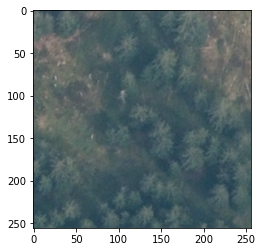

In [12]:
plt.imshow(images.permute(0, 2, 3, 1).numpy()[7,:,:,:3])

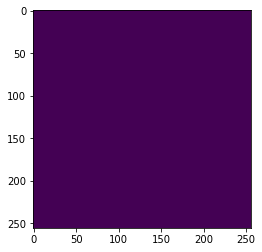

In [13]:
plt.imshow(labels.permute(0, 2, 3, 1).numpy()[7,:,:,:])

In [14]:
labels[7,:,:,:]

tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         ...,
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
         [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]]])

## Model Architecture

In [14]:
class convBlock(nn.Module):
    def __init__(self, in_channels, filters, size, stride = 1, activation = True):
        super(convBlock, self).__init__()
        self.activation = activation
        self.conv = nn.Conv2d(in_channels, filters, size, stride = stride, padding = size//2)
        self.norm = nn.BatchNorm2d(filters)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        if self.activation:
            return F.relu(x)
        else:
            return x
    
class residualBlock(nn.Module):
    def __init__(self, in_channels, filters, size = 3):
        super(residualBlock, self).__init__()

        self.norm = nn.BatchNorm2d(in_channels)
        self.conv1 = convBlock(in_channels, filters, size)
        self.conv2 = convBlock(filters, filters, size, activation=False)

    def forward(self, x):
        residual = x  
        x = F.relu(x)
        x = self.norm(x)
        x = self.conv1(x)
        x = self.conv2(x)
        #x += residual
        return x 
    
class deconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 2, stride = 2):
        super(deconvBlock, self).__init__()
        
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)

    def forward(self, x1, x2):
        xd = self.deconv(x1)
        x = torch.cat([xd, x2], dim = 1)
        return x

In [18]:
class UnetModel(nn.Module):

    def __init__(self, filters = 16, dropout = 0.5):
        super(UnetModel, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, filters, 3, padding = 1),
            residualBlock(filters, filters),
            residualBlock(filters, filters),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, filters * 2, 3, padding = 1),
            residualBlock(filters * 2, filters * 2),
            residualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )
        
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters * 4, 3, padding = 1),
            residualBlock(filters * 4, filters * 4),
            residualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 8, 3, padding = 1),
            residualBlock(filters * 8, filters * 8),
            residualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
            

        self.middle = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 16, 3, padding = 3//2),
            residualBlock(filters * 16, filters * 16),
            residualBlock(filters * 16, filters * 16),
            nn.ReLU()
        )
        
        self.deconv4 = deconvBlock(filters * 16, filters * 8, 2)
        self.upconv4 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 16, filters * 8, 3, padding = 1),
            residualBlock(filters * 8, filters * 8),
            residualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
  

        self.deconv3 = deconvBlock(filters * 8, filters * 4, 3)
        self.upconv3 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 4, 3, padding = 1),
            residualBlock(filters * 4, filters * 4),
            residualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        self.deconv2 = deconvBlock(filters * 4, filters * 2, 2)
        self.upconv2 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 2, 3, padding = 1),
            residualBlock(filters * 2, filters * 2),
            residualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )

        self.deconv1 = deconvBlock(filters * 2, filters, 3)
        self.upconv1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters, 3, padding = 1),
            residualBlock(filters, filters),
            residualBlock(filters, filters),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, 1, 3, padding = 1)
        )

    def forward(self, x):
        conv1 = self.conv1(x) 
        # 101 -> 50
        conv2 = self.conv2(conv1) 
        # 50 -> 25
        conv3 = self.conv3(conv2) 
        # 25 -> 12
        conv4 = self.conv4(conv3) 
        # 12 - 6
        x = self.middle(conv4) 
        
        # 6 -> 12
        x = self.deconv4(x, conv4)
        x = self.upconv4(x)
        # 12 -> 25
        x = self.deconv3(x, conv3)
        x = self.upconv3(x)
        # 25 -> 50
        x = self.deconv2(x, conv2)
        x = self.upconv2(x)
        # 50 -> 101
        x = self.deconv1(x, conv1)
        x = self.upconv1(x)

        return x

In [15]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [16]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


## Model training

In [16]:
def get_iou_score(outputs, labels):
    A = labels.squeeze().bool()
    pred = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
    B = pred.squeeze().bool()
    intersection = (A & B).float().sum((1,2))
    union = (A | B).float().sum((1,2)) 
    iou = (intersection + 1e-6) / (union + 1e-6)  
    return iou

In [17]:
def get_iou_score(outputs, labels, num_classes=4):
    iou_list = []
    for c in range(num_classes):
        A = labels.squeeze()==c/255
        #pred = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
        pred = outputs
        B = pred.squeeze()==c/255
        intersection = (A & B).float().sum((1,2))
        union = (A | B).float().sum((1,2)) 
        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_list.append(iou)
    return sum(iou_list)/num_classes

In [18]:
get_iou_score(labels, labels)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [19]:

# Usage Example:
num_epochs = 10
for epoch in range(num_epochs):
    # Train:   
    for batch_index, (faces, labels) in enumerate(train_loader):
        # ...

SyntaxError: unexpected EOF while parsing (<ipython-input-19-9a3fd4aaf95a>, line 6)

In [ ]:
####

In [17]:
def get_iou_score(outputs, labels, num_classes=4):
    iou_list = []
    for c in range(num_classes):
        A = labels.squeeze()==c
        #pred = torch.where(outputs<0., torch.zeros_like(outputs), torch.ones_like(outputs))
        pred = outputs
        B = pred.squeeze()==c
        intersection = (A & B).float().sum((1,2))
        union = (A | B).float().sum((1,2)) 
        iou = (intersection + 1e-6) / (union + 1e-6)
        iou_list.append(iou)
    return sum(iou_list)/num_classes
  
def train_one_batch(model, x, y):
    
    x = x.to(device=device, dtype=torch.float32) 
    y = y.to(device=device, dtype=torch.float32)
    
    outputs = model(x)
    loss = loss_fn(outputs, y)
    iou = get_iou_score(outputs, y).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item(), iou.item()

In [18]:
NUM_EPOCHS = 3
BATCH_SIZE = batch_size

model = UNet(n_channels=4, n_classes=1).to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.CrossEntropyLoss(), lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

#train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
#steps  = train_dataset.__len__() // BATCH_SIZE
steps = len(train_indices) // BATCH_SIZE
print(steps,"steps per epoch")

start = time.time()
train_losses = []
train_ious = []
for epoch in range(1, NUM_EPOCHS + 1):
    print('-' * 10)
    print('Epoch {}/{}'.format(epoch, NUM_EPOCHS))
    running_iou = []
    running_loss = []
    for step, (x, y) in enumerate(train_dataloader):
        loss, iou = train_one_batch(model, x, y)
        running_iou.append(iou)
        running_loss.append(loss)
        print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}'.format(100*(step+1)/steps, loss,iou), end = "") 
        
    print('\r{:6.1f} %\tloss {:8.4f}\tIoU {:8.4f}\t{}'.format(100*(step+1)/steps,np.mean(running_loss),np.mean(running_iou), timeSince(start)))
    scheduler.step(np.mean(running_iou))
    
    train_losses.append(loss)
    train_ious.append(iou)

7230 steps per epoch
----------
Epoch 1/3
 100.0 %	loss   0.0541	IoU   0.9767	34m 49s
----------
Epoch 2/3
 100.0 %	loss   0.0518	IoU   0.9767	70m 2s
----------
Epoch 3/3
 100.0 %	loss   0.0518	IoU   0.9767	105m 11s


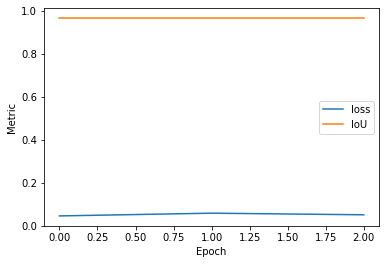

In [19]:
## plot loss
plt.plot(train_losses, label = 'loss')
plt.plot(train_ious, label = 'IoU')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [20]:
## save weights    
torch.save(model.cpu().state_dict(), model_path)

model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

## Make predictions

In [21]:
# Run this to test your data loader
images, labels = next(iter(train_dataloader))

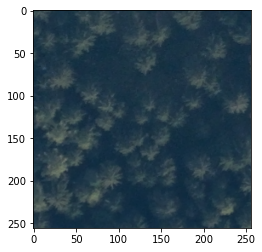

In [22]:
plt.imshow(images.permute(0, 2, 3, 1).numpy()[7,:,:,:3])

In [23]:
outputs = model(images)

In [25]:
plt.imshow(outputs.permute(0, 2, 3, 1).numpy()[7,:,:,:])

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.